# Introduction

Pneumonia is a respiratory infection caused by bacteria or viruses; it affects many individuals, especially in developing and underdeveloped nations, where high levels of pollution, unhygienic living conditions, and overcrowding are relatively common, together with inadequate medical infrastructure. Pneumonia causes pleural effusion, a condition in which fluids fill the lung, causing respiratory difficulty. Early diagnosis of pneumonia is crucial to ensure curative treatment and increase survival rates. Chest X-ray imaging is the most frequently used method for diagnosing pneumonia. However, the examination of chest X-rays is a challenging task and is prone to subjective variability. In this study, we developed a computer-aided diagnosis system for automatic pneumonia detection using chest X-ray images. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import keras
from keras.models import Model,load_model
from keras.layers import Dense,Flatten,Dropout
from keras import optimizers,losses
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array,load_img
from keras.applications.vgg16 import VGG16,preprocess_input

### Load & Augment the dataset 

In [2]:
train_gen = ImageDataGenerator(rescale=1./255.,
                               rotation_range=45,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.2,
                               vertical_flip=True,
                               fill_mode='nearest',
                               validation_split=0.2,
                               preprocessing_function=preprocess_input)

train_data = train_gen.flow_from_directory('./train',
                                           target_size=(224,224),
                                           class_mode='categorical',
                                           subset='training',
                                           shuffle = True,batch_size=100)


valid_data = train_gen.flow_from_directory('./train',shuffle = True,
                                           target_size=(224,224),subset='validation',
                                           class_mode='categorical',
                                           batch_size=100)

test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory('./test',shuffle = False,
                                         target_size=(224,224),class_mode='categorical')

Found 8065 images belonging to 3 classes.
Found 2014 images belonging to 3 classes.
Found 928 images belonging to 3 classes.


# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. 
> Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. 

In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture, with a series of convolutional and maxpooling layers, then three fully-connected layers at the end that classify the 1000 classes found in the ImageNet database.


<img src=".\img\Screenshot 2022-08-29 203621.png" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but **replace the final fully-connected layer** with our own classifier. This way we can use VGGNet as a _fixed feature extractor_ for our images then easily train a simple classifier on top of that. 

## Load & Fine-tuning VGG-16 Model

In [14]:
vgg = VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

In [15]:
vgg.trainable = False

In [16]:
base_model = Flatten()(vgg.output)
base_model = Dense(3,activation = 'softmax')(base_model)
model = Model(inputs = vgg.inputs,outputs = base_model)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Compile & Fit 

In [17]:
adam = optimizers.Adam()#learning_rate=0.000001,clipnorm=1.0,clipvalue=0.5)
model.compile(optimizer = adam,loss=losses.CategoricalCrossentropy(),metrics=[keras.metrics.CategoricalAccuracy()])

In [18]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(filepath='chest_xray.h5',verbose=2,monitor="val_loss",save_best_only=True)
earlystopping = EarlyStopping(monitor="val_loss",patience=3,verbose=1,restore_best_weights=True)
callbacks = [checkpoint,earlystopping]

start = datetime.now()

model_history = model.fit(train_data,
                        validation_data=valid_data,
                        epochs = 25,
                        steps_per_epoch = len(train_data),
                        validation_steps=len(valid_data),
                        shuffle=True,
                        callbacks = callbacks,verbose = 2)

duration = datetime.now() - start
print("train completed in time: ", duration)
print("Number of epochs: ",len(model_history.history['val_loss']))

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.31825, saving model to chest_xray.h5
81/81 - 355s - loss: 0.4758 - categorical_accuracy: 0.8264 - val_loss: 0.3182 - val_categorical_accuracy: 0.8793 - 355s/epoch - 4s/step
Epoch 2/25

Epoch 2: val_loss improved from 0.31825 to 0.26719, saving model to chest_xray.h5
81/81 - 344s - loss: 0.2650 - categorical_accuracy: 0.9127 - val_loss: 0.2672 - val_categorical_accuracy: 0.8962 - 344s/epoch - 4s/step
Epoch 3/25

Epoch 3: val_loss improved from 0.26719 to 0.22079, saving model to chest_xray.h5
81/81 - 348s - loss: 0.2389 - categorical_accuracy: 0.9178 - val_loss: 0.2208 - val_categorical_accuracy: 0.9280 - 348s/epoch - 4s/step
Epoch 4/25

Epoch 4: val_loss did not improve from 0.22079
81/81 - 346s - loss: 0.2179 - categorical_accuracy: 0.9246 - val_loss: 0.2805 - val_categorical_accuracy: 0.9002 - 346s/epoch - 4s/step
Epoch 5/25

Epoch 5: val_loss did not improve from 0.22079
81/81 - 345s - loss: 0.2042 - categorical_accuracy: 0.9275 -

## Test The Model 

In [3]:
vgg_model = load_model('chest_xray.h5')
test_history = vgg_model.evaluate(test_data,steps = len(test_data),verbose = 1)
print("Accuarcy of test: {:.2f}%".format(test_history[1]*100))

29/29 [==============================] - 47s 1s/step - loss: 0.2510 - categorical_accuracy: 0.9052
Accuarcy of test: 90.52%


## predict subset of Test Data

In [4]:
def upload_data(data_dir,categories):
    """
    Parameters:
    data_dir (path):file path of the dataset
    categorie (list):list of classes of the dataset
    
    Returns:
    list: list of array of image and label of the image
    
    """
    data = []
    for category in categories:
        path = os.path.join(data_dir,category)
        #Convert label to number (NORMAL = 0) & (PNEUMONIA = 1) & (COVID = 2)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            new_img = cv2.resize(img_array,(224,224))
            data.append([new_img/255.0,class_num])
    
    #Shuffle the data 
    random.shuffle(data)
    return data

categories = ['COVID','NORMAL','PNEUMONIA']
test = upload_data('./test',categories)

In [5]:
x = []
y = []
for image,label in test:
    x.append(image)
    y.append(label)
    
#convert list to array, to feed it to neural network
x = np.array(x).reshape(-1,224,224,3)
y = np.array(y)

1/1 [==============================] - 0s 42ms/step


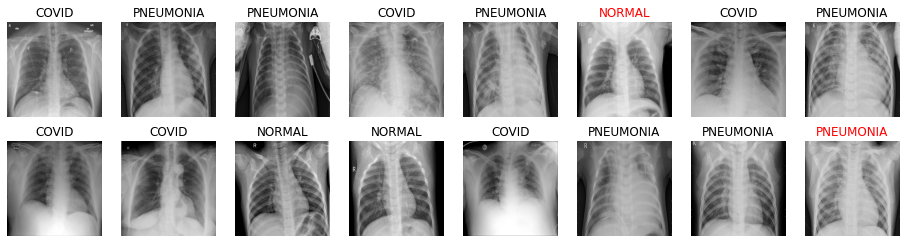

In [6]:
fig,ax = plt.subplots(2,8,figsize = (16,4))

for i,ax in enumerate(ax.flat):
    random_index = np.random.randint(x.shape[0])
    ax.imshow(x[random_index])
    img = np.expand_dims(x[random_index], axis=0)
    y_pred = vgg_model.predict(img)
    yhat = np.argmax(y_pred)
    
    if y[random_index] != yhat:
        ax.set_title(categories[yhat],color = "red")
    else:
        ax.set_title(categories[yhat])
    ax.set_axis_off()

## Predict Chest X-Ray Images

In [59]:
def predict(image_1,image_2 = None):
    """
    Parameters:
    image_1 (path): path of Chest X-Ray image 
    image_2 (path): (optionial) path of Chest X-Ray image 
  
    Returns:
    str: the prediction of Chest X-Ray image (NORMAL) or (PNEUMONIA) or (COVID)
    
  """
    categories = ['COVID','NORMAL','PNEUMONIA']
    if image_2 == None:
        img_array = cv2.imread(image_1)
        img_array = cv2.resize(img_array,(224,224))/255.
        img = np.expand_dims(img_array, axis=0)
        y_pred = vgg_model.predict(img)
        yhat = np.argmax(y_pred)
    else:
        array_of_images = np.zeros((2,224,224,3))
        img_array = cv2.imread(image_1)
        array_of_images[0,:] = cv2.resize(img_array,(224,224))/255.0
        img_array = cv2.imread(image_2)
        array_of_images[1,:] = cv2.resize(img_array,(224,224))/255.0
        y_pred = vgg_model.predict(array_of_images)
        y_pred_sum = np.sum(y_pred,axis = 0) / 2
        yhat = np.argmax(y_pred_sum)
        
    return categories[yhat]

In [60]:
predict('./train/PNEUMONIA/person1_bacteria_1.jpeg','./train/PNEUMONIA/person1_bacteria_2.jpeg')

1/1 [==============================] - 0s 41ms/step


'PNEUMONIA'